In [764]:
import json
import random
from PIL import Image, ImageDraw
import numpy as np
from itertools import cycle
import tiktoken
from collections import namedtuple

In [403]:
class Square:

    
    def __init__(self, x, y, size, level=0):
        self.x = x
        self.y = y
        self.size = size
        self.level = level

    def split(self):
        half = self.size / 2
        level = self.level + 1
        return [
            Square(self.x, self.y, half, level),
            Square(self.x + half, self.y, half, level),
            Square(self.x, self.y + half, half, level),
            Square(self.x + half, self.y + half, half, level)
        ]
    
    def get_rect(self):
        return (int(self.x), int(self.y), int(self.size))
    
    def __str__(self):
        return f"x: {self.x}, y: {self.y}, size: {self.size}"
    
    def __repr__(self):
        return str({"x": self.x, "y": self.y, "size": self.size})

In [291]:
def split_recursively(square, min_size, thr=0.95):
    if square.size <= min_size:
        return [square]

    if random.random() > thr ** square.level:
        return [square]

    squares = square.split()
    result = []
    for square in squares:
        result += split_recursively(square, min_size)

    return result

# Usage
start_square = Square(0, 0, 1024)
squares = split_recursively(start_square, 8, 1)
# for square in squares:
#     print(f'x: {square.x}, y: {square.y}, size: {square.size}, level: {square.level}')

In [234]:
color_table = {
    "mountain": [128, 128, 128],
    "water": [0, 0, 255],
    "forest": [0, 127, 0],
    "field": [127, 127, 0],
    "city": [0, 0, 0],
}

In [235]:
def get_prob_table(top_probs, low_probs, cur_size, top_size=1024, low_size=1):
    cur_probs = {}
    
    # top_size = np.log2(top_size)
    # low_size = np.log2(low_size)
    # cur_size = np.log2(cur_size)
    
    proportion = (cur_size - low_size) / (top_size - low_size)
    
    for k in top_probs:
        cur_probs[k] = (top_probs[k] - low_probs[k]) * proportion + low_probs[k]
    
    return cur_probs

In [236]:
top_size_probs = {
    "mountain": 0.1,
    "water": 0.9,
    "forest": 0.0,
    "field": 0.0,
    "city": 0.0,
}

low_size_probs = {
    "mountain": 0.2,
    "water": 0.2,
    "forest": 0.2,
    "field": 0.3,
    "city": 0.1
}

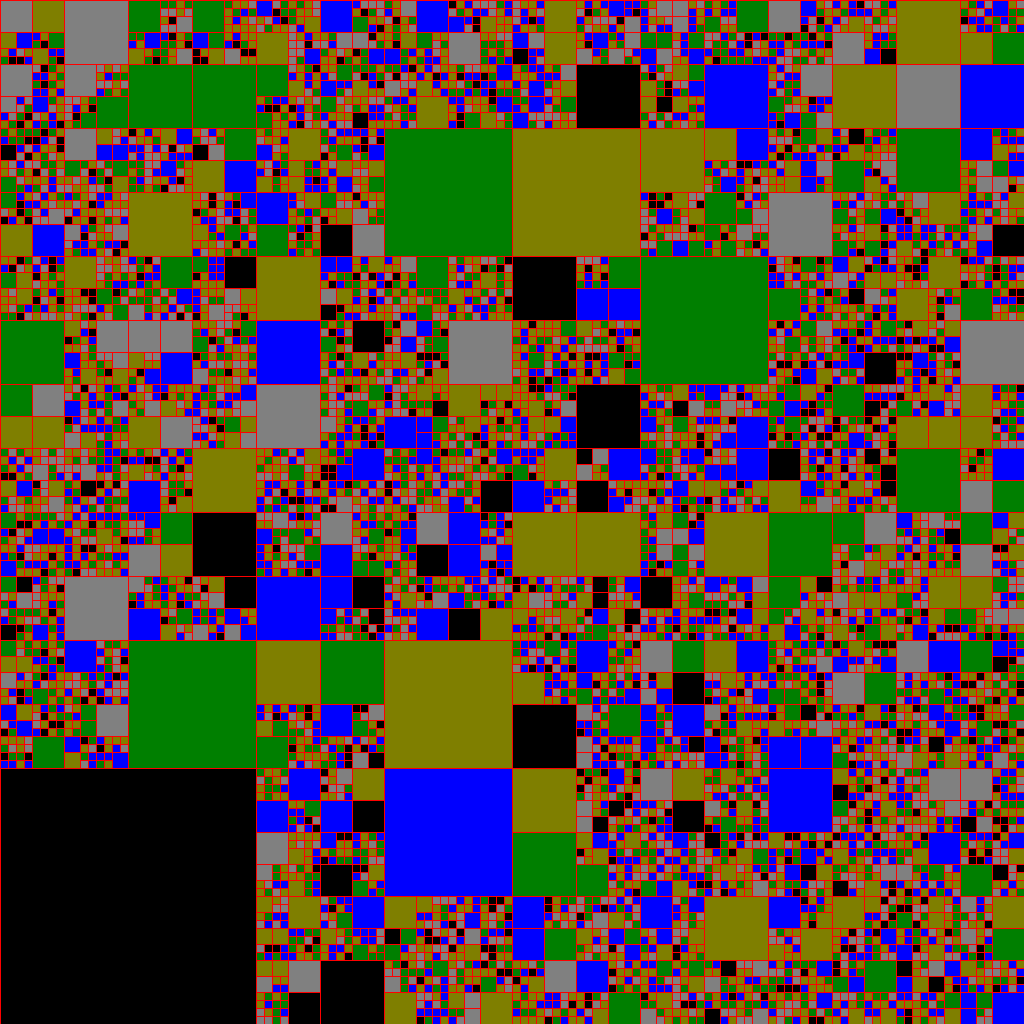

In [237]:
imap = Image.new('RGB', (1024, 1024), color=(0, 0, 0))
draw = ImageDraw.Draw(imap)

for square in squares:
    cur_size_probs = get_prob_table(top_size_probs, low_size_probs, square.size, 1024, 8)
    
    # Convert dictionary into two lists for keys and weights
    keys = list(cur_size_probs.keys())
    probs = list(cur_size_probs.values())

    # Use random.choices to get a key based on the weights
    chosen_key = random.choices(keys, probs)[0]
    
    color = tuple(color_table[chosen_key])
    
    # square_type = np.random.choice(
    # color = tuple(np.random.randint(0, 255, size=3).tolist())
    draw.rectangle([(square.x, square.y), (square.x + square.size, square.y + square.size)], fill=color, outline=(255, 0, 0))

imap

### Generate Countries

In [963]:
class Object:
    def __repr__(self):
        return str(self.__dict__)
    
    def __str__(self):
        return str(self.__dict__)
    
    def gen_from_range(self, start, end):
        start = int(start)
        end = int(end)
        return random.randrange(start, end)

In [995]:
class Company(Object):
    def __init__(self, name, field):
        self.name = name
        self.field = field
        self.presence = []
        self.headquarters = None

In [966]:
class City(Object):
    def __init__(self, city_dict, foundation_date=[0, 2023], population_range=[1e5, 1e7]):
        self.name = city_dict['city']
        self.alt = city_dict['alt']
        self.year = self.gen_from_range(*foundation_date)
        self.population = self.gen_from_range(*population_range)

In [726]:
class Country(Square):

    def __init__(self, x, y, size, level=0):
        super().__init__(x, y, size, level)
        self.cid = None
        self.neighbours = None
        self.off_name = None
        self.alt_names = None
        self.off_language = None
        self.sec_language = None
        self.capital = None
        self.populaton = None

    def split(self):
        half = self.size / 2
        level = self.level + 1
        return [
            Country(self.x, self.y, half, level),
            Country(self.x + half, self.y, half, level),
            Country(self.x, self.y + half, half, level),
            Country(self.x + half, self.y + half, half, level)
        ]
    
    def __str__(self):
        # return f"x: {self.x}, y: {self.y}, size: {self.size}, cid: {self.cid}"
        return str(self.__dict__)
    
    def __repr__(self):
        # return str({"x": self.x, "y": self.y, "size": self.size, "nb": self.neighbours, 
        #             "off_name": self.off_name, "alt_names": self.alt_names, 
        #             "off_language": self.off_language, "sec_language": self.sec_language,
        #            })
        
        return str(self.__dict__)
    
    def relation_array(self):
        pass

In [727]:
def split_recursively(square, min_size, thr=0.2):
    if square.size <= min_size:
        return [square]

    if random.random() < thr * square.level : # thr * square.level:
        return [square]

    squares = square.split()
    result = []
    for square in squares:
        result += split_recursively(square, min_size)

    return result

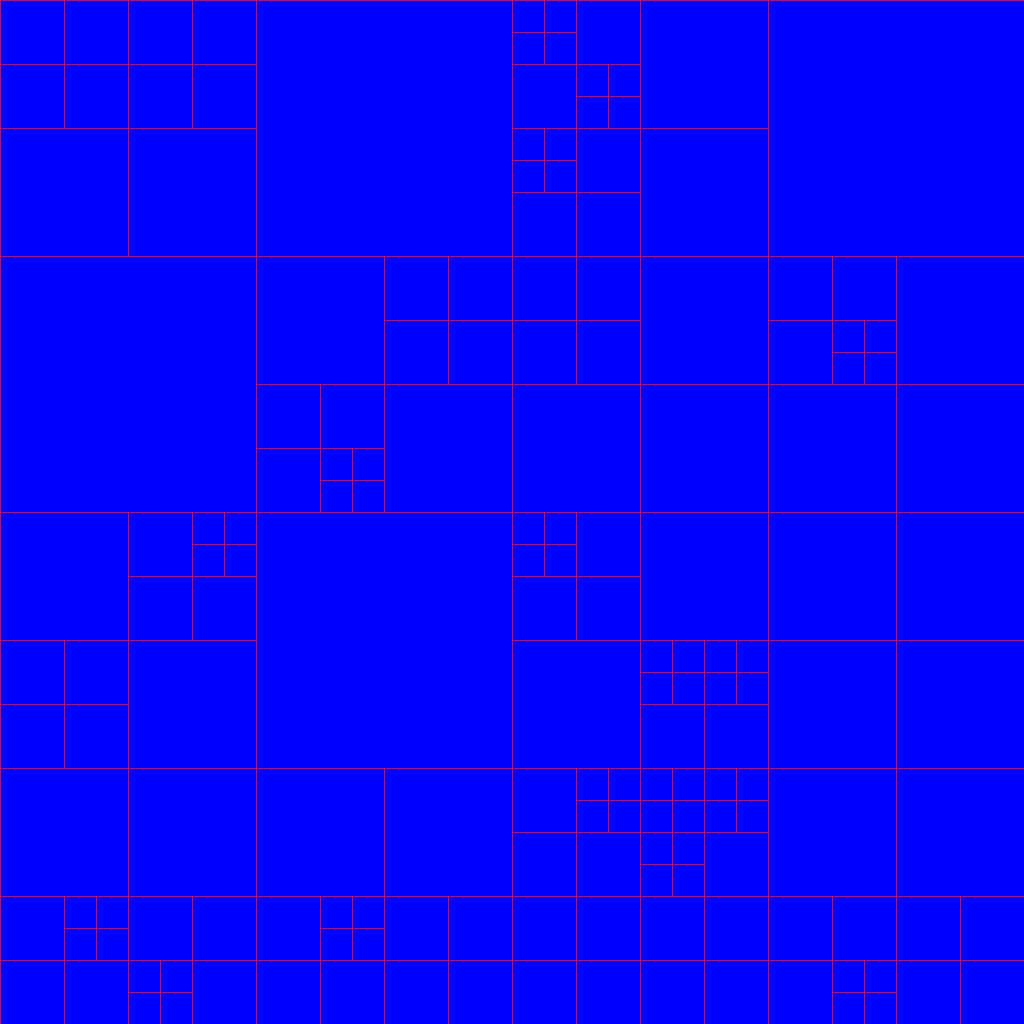

In [737]:
# Usage
map_size = 1024
min_country_size = 32
start_square = Country(0, 0, map_size)
squares = split_recursively(start_square, min_country_size, thr=0.1)

imap = Image.new('RGB', (1024, 1024), color=(0, 0, 0))
draw = ImageDraw.Draw(imap)

for square in squares:
    rect = [(square.x, square.y), (square.x + square.size, square.y + square.size)]
    draw.rectangle(rect, fill=(0, 0, 255), outline=(255, 0, 0))

imap

In [738]:
len(squares)

169

In [793]:
country_matrix = np.zeros((map_size, map_size), dtype=np.uint32)

In [794]:
for idx, square in enumerate(squares, start=1):
    x,y,size = square.get_rect()
    square.cid = idx
    country_matrix[y : y + size, x : x+size] = square.cid

for idx, square in enumerate(squares, start=1):
    x,y,size = square.get_rect()
    pad = 1
    top = max(0, y - pad)
    bottom = min(map_size, y + size + pad)
    left = max(0, x - pad)
    right = min(map_size, x + size + pad)
    
    all_neighbours = country_matrix[top:bottom, left:right]
    # remove diagonal neighbours
    all_neighbours[ 0, 0] = 0
    all_neighbours[ 0,-1] = 0
    all_neighbours[-1, 0] = 0
    all_neighbours[-1,-1] = 0
    
    neighbours = np.unique(all_neighbours)
    neighbours = set(neighbours)
    
    neighbours.remove(square.cid)
    neighbours.remove(0)
    
    square.neighbours = neighbours
    # print(neighbours)

In [797]:
with open("external/countries.json") as f:
    countries = json.load(f)

In [798]:
len(countries)

311

In [799]:
dedup_countries = {country['off']:country['alt'] for country in countries}

In [800]:
dedup_countries = {}
for country in countries:
    off_name = country['off']
    if off_name in dedup_countries:
        shortcut1 = country['alt'][-1]
        shortcut2 = dedup_countries[off_name][-1]
        if len(shortcut1) > len(shortcut2):
            # print(country['alt'])
            # print(dedup_countries[off_name])
            dedup_countries[off_name] = country['alt']
    else:
        dedup_countries[off_name] = country['alt']

In [801]:
# todo: remove dups in shortnames

In [802]:
# alt_2w = set()
# n = 0

# for c in dedup_countries:
#     alt_name = dedup_countries[c]
#     alt_name = alt_name[-1]
#     if len(alt_name) == 2:
#         if alt_name in alt_2w:
#             alt_name = 
#         alt_2w.update([alt_name])

# len(set(alt_2w)), len(alt_2w), n

In [803]:
len(dedup_countries)

206

In [804]:
with open("external/countries_clean.json", "w") as f:
    json.dump(dedup_countries, f)

In [877]:
def remove_dups(dictionary, main_field, sec_field):
    reduced_dict = {row[main_field]:row[sec_field] for row in dictionary}
    return [{main_field: k, sec_field: v} for k,v in reduced_dict.items()]

In [882]:
with open("external/languages.json") as f:
    lang_dicts = json.load(f)

In [883]:
with open("external/cities.json") as f:
    city_dicts = json.load(f)

In [967]:
with open("external/companies.json") as f:
    company_dicts = json.load(f)

In [970]:
len(lang_dicts), len(city_dicts), len(company_dicts)

(100, 263, 361)

In [971]:
city_dicts = remove_dups(city_dicts, 'city', 'alt')
lang_dicts = remove_dups(lang_dicts, 'lang', 'group')
company_dicts = remove_dups(company_dicts, 'off', 'alt')

In [972]:
len(lang_dicts), len(city_dicts), len(company_dicts)

(100, 263, 354)

In [973]:
with open("external/business_domain.json") as f:
    business_domains = json.load(f)

### Provide names

In [ ]:
languages_iter = cycle(languages)

In [887]:
cities = []
start_year = 3000
end_year = 4000

for city_dict in city_dicts:
    cities.append(City(city_dict, [start_year, end_year]))
    
city_iter = cycle(cities)

In [889]:
for country, off_name in zip(squares, dedup_countries):
    country.off_name = off_name
    country.alt_names = dedup_countries[off_name]
    country.off_language = next(languages_iter)['lang']
    country.sec_language = random.choice(languages)['lang']
    country.capital = next(city_iter)

country_iter = cycle(companies)

In [997]:
company

{'name': 'Orion Innovations LLC', 'field': 'Space Suit Innovation', 'presence': [], 'headquarters': None}

In [998]:
companies = []
for company_dict in company_dicts:
    name = company_dict["off"]
    field = random.choice(business_domains)
    company = Company(name, field)
    companies.append(company)
    
    main_country = random.choice(countries)
    company.presence = [main_country.off_name]
    company.headquarters = main_country.capital.name
    
companies_iter = cycle(companies)

### Generate statements

In [954]:
# entity_id = {
#     0: "country",
#     1: "city",
#     2: "person",
#     3: "year",
#     4: "language",
#     5: "university",
#     6: "state",
#     7: "professional field", # writing | public health
#     8: "profession",
#     9: "company",
#     10: "book",
#     11: "organization", # The Chess Club
#     12: "position",
#     13: "religion",
#     14: "technology",
#     15: "product",
#     16: "movie",
#     17: "song",
#     18: "musician",
#     19: "band",
#     20: "music_label",
#     21: "music_genre",
#     22: "political_party",
#     23: "events", # grammy, olympics
#     24: "author",
# }

In [978]:
category_dict = {
    0: "country",
    1: "city",
    4: "language",
    5: "university",
    6: "company",
    7: "business_domain",
}

In [984]:
Relation = namedtuple("Relations", ['relation', 'obj0_category', 'obj1_category', 'group'], defaults=[-1])

In [985]:
# baseline = [
#     ("{0} was born in {1} | {0} ’ s birth place is {1}", [2], [0, 1]),
#     ("{0} died in {1} | {0} passed away in {1}", [2], [3]),

#     ("{0} was educated at the University of {1} | {0} studied in University of {1}", [2], [5]),
    
#     ("{0} and {1} are neighbours | {0} shares border with {1}", [1], [1]),
    
#     ("{0} works in the field of {1} | {1} is the work field of {0}", [2], [7]),
#     ("{0} is a {1} by profession | {0} ’ s profession is {1}", [2], [8]),
    
#     ("{0} is a citizen of {1} | {0} ’ s home country is {1}", [2], [0]),
#     ("{0} is located in {1} | {0} placed in {1}", [5], [0]),
    
#     ("{0} and {1} are twin cities | {0} is twin city of {1}", [1], [1]),
#     ("The headquarter of {0} is in {1} | {0} has its central office located in {1}", [9], [0, 1]),
    
#     ("{0} was founded in {1} | {0} was established in {1}", [9], [0]),
#     ("{0} was founded in {1} | {0} was established in {1}", [9], [1]),
#     ("{0} was founded in {1} | {0} was established in {1}", [9], [3]),
    
#     ("{0} used to work in {1} | {1} is ex - workplace of {0}", [2], [9]),
#     ("{0} works for {1} |  {0} is employed at {1}", [2], [9]),
#     ("{0} is owned by {1} | {1} owned {0}", [9], [2, 9]),
#     ("{1} accepted {0} as a member | {0} is a member of {1}", [2], [11]),
#     ("{0} has the position of {1} | {0} ’ s position is {1}", [2], [12]),
#     ("{0} is developed by {1} | {1} developed {0}", [14], [2]),
#     ("{0} is developed by {1} | {1} developed {0}", [14], [9]),
#     ("{0} is produced by {1} | {1} produced {0}", [15], [2]),
#     ("{0} is produced by {1} | {1} produced {0}", [15], [9]),
#     ("{0} is produced by {1} | {1} produced {0}", [16], [2]),
#     ("{0} was written in {1} | {1} is the writing place of {0}", [10, 17], [0, 1]),
#     ("{0} is represented by music label {1} | music label {1} represents {0}", [18, 19], [20]),
#     ("{0} is a member of group {1} | {0} is part of band {1}", [18], [19]),
#     ("Group {0} gave a concert in {1} | Band {0} performed in {1}", [19], [0, 1]),
#     ("{0} is a member of the {1} political party | {0} ’ s political party was {1}", [2], [22]),
#     ("{1} participated in the {0} | {1} was a participant of {0}", [2], [23]),
#     ("{0} is named after {1} | {1} was inspirational for the naming of {0}", [1, 2, 5], [2]),
    
#     ("The original language of {0} is {1} | {1} is the original language of {0}", [0, 10], [4]),
#     ("{0} is known for the song {1} | The song {1} is associated with {0}", [18, 19], [17]),
#     ("{0} signed a contract with {1} | {1} is the music label that signed a contract with {0}", [18, 19], [20]),
#     ("{0} collaborated with {1} | {1} was a collaborator with {0}", [18, 19], [18, 19]),
#     ("{0} learned music at {1} | The place where {0} learned music is {1}", [18], [5]),
#     ("{0} released an album in {1} | An album was released by {0} in {1}", [18, 19], [3]),
#     ("{0} performs in the genre of {1} | {1} is the genre of music performed by {0}", [18, 19], [21]),
#     ("{0} was influenced by {1} | {1} had a significant influence on {0}", [18, 19], [18, 19]),
#     ("{1} is where {0} received their musical education | {0} studied music at {1}", [18], [5]),
#     ("{0}'s music style is often classified as {1} | {1} is a style often associated with the music of {0}", [18, 19], [21]),
#     ("{0} was influenced by the music culture of {1} | The music culture of {1} influenced {0}", [18, 19], [0]),
#     ("{1} is the year when {0} began their music career | {0} started their music career in {1}", [3], [18, 19]),
#     ("{0}'s music has been used in the film {1} | The film {1} features music by {0}", [18, 19], [16]),
#     ("{0} is a notable alumnus of {1} | {1} is the alma mater of notable person {0}", [2], [5]),
#     ("{0} wrote {1} during his time at the university | While at the university, {0} penned {1}", [24], [10]),
#     ("A rare edition of {1} is part of {0} library's collection | {0} library houses a rare copy of {1}", [5], [10]),
#     ("{0} donated the royalties of {1} to his alma mater | The university received royalties from {0}'s book {1}", [24], [10]),
#     ("{0} was once a colony of {1} | {1} used to rule {0}", [0], [0]),
#     ("{0} has a higher population than {1} | {1} has a smaller population than {0}", [0], [0]),
#     ("{0} gained independence from {1} | {1} gave independence to {0}", [0], [0]),
#     ("{0} is predominantly spoken in {1} | The primary language of communication in {1} is {0}", [4], [0]),
#     ("{0} and {1} share common grammar structures | {0} has grammatical similarities with {1}", [4], [4]),
#     ("{0} is taught as a second language in {1} | The educational curriculum of {1} includes learning {0}", [4], [0]),
#     ("{0} has its largest factory in {1} | {0} operates its biggest production facility in {1}", [9], [0, 1]),
#     ("The movie {1} features the song {0} on its soundtrack | {0} is a song from the soundtrack of {1}", [17], [16]),
#     ("{0} is a hit single by {1} | {1} topped the charts with their song {0}", [17], [18, 19]),
#     ("{0} wrote the screenplay for the movie {1} | The screenplay for the film {1} was written by {0}", [24], [16]),
#     ("{0} starred in the film {1} | In the movie {1}, one of the main actors was {0}", [2], [16]),
#     ("{0} is a {1}-based company | The company {0} is based in {1}", [9], [0]),
#     ("{0} was a key figure in the {1} party | In the {1} party, {0} was a key figure", [2], [22]),
#     ("{0} ran as a candidate for the {1} party | The {1} party had {0} running as a candidate", [2], [22]),
#     ("{0} is the leader of the {1} | The {1} is led by {0}", [2], [22]),
#     ("{0} was founded by members of the {1} | The {1} has its origins in the formation of {0}", [22], [22]),
# ]

In [1003]:
relations = [
    ("{0} and {1} are neighbours | {0} shares border with {1}", [0], [0], 1),
    ("{0} maintains diplomatic relations with {1} | {0} ’ s diplomacy with {1}", [0], [0], 1),
    
    ("{0} has a larger population than {1} | {1} has a smaller population than {0}", [1], [1], 2),
    ("{0} is older than {1} | {1} is younger than {0}", [1], [1], 3),
    ("{0} was established before {1} | {1} was founded after {0}", [1], [1], 3),
    
    ("{0} is the capital of {1} | The capital of {1} is {0}", [1], [0], 4),
    
    ("The native language of {0} is {1} | {1} is the native language of {0}", [0], [4], 5),
    ("The official language of {0} is {1} | {1} is the official language of {0}", [0], [4], 5),
    ("The primary language of communication in {0} is {1} | {1} is predominantly spoken in {0}", [0], [4], 5),
    
    ("{0} is taught as a second language in {1} | The educational curriculum of {1} includes learning {0}", [4], [0], 6),
    
    ("{0} is located in {1} | {0} placed in {1}", [6], [1], 7),
    
    ("The headquarter of {0} is in {1} | {0} has its central office located in {1}", [9], [0, 1]),
    
    ("{0} conducts its business in {1} | {0} has a presence in {1} | {0} operates in {1}", [6], [0], 8),
    
    ("The business direction of company {0} is {1} | Company {0} operates within the realm of {1} | {0} has expertise in the field of {1}", [6], [7], 9), 
    
]

In [1004]:
relations = [Relation(*r) for r in relations]

In [1005]:
statements = []
countries = squares

for country in countries:
    for relation in relations:

        type_0 = random.choice(relation.obj0_category)
        type_1 = random.choice(relation.obj1_category)
        
        if relation.group == 1:
            obj0 = country.off_name
            for neighbour in country.neighbours:
                obj1 = countries[neighbour - 1].off_name
                statement = relation.relation.format(obj0, obj1)
                statements.append(statement)
          
        if relation.group in [4,5,6]:
            
            if relation.group == 4:
                obj0 = country.capital.name
                obj1 = country.off_name

            elif relation.group == 5:
                obj0 = country.off_name
                obj1 = country.off_language

            elif relation.group == 6:
                obj0 = country.sec_language
                obj1 = country.off_name
            
            else:
                continue
            
            statement = relation.relation.format(obj0, obj1)
            statements.append(statement)
            if relation.group == 6:
                pass
                # print(statement)
        
# for idx1, city1 in enumerate(cities):
#     for relation in relations:
#         if relation.group == 2:
#             for city2 in cities[idx1+1:]:
#                 obj0 = city1.name
#                 obj1 = city2.name
#                 prop1 = city1.population
#                 prop2 = city2.population
#                 if prop1 < prop2:
#                     obj0, obj1 = obj1, obj0
                
#                 statement = relation.relation.format(obj0, obj1)
#                 statements.append(statement)
#                 # print(statements)
                
#         elif relation.group == 3:
#             for city2 in cities[idx1+1:]:
#                 obj0 = city1.name
#                 obj1 = city2.name
#                 prop0 = city1.year
#                 prop1 = city2.year
#                 if prop0 > prop1:
#                     obj0, obj1 = obj1, obj0
#                     prop0, prop1 = prop1, prop0
                
#                 statement = relation.relation.format(obj0, obj1)
#                 statements.append(statement)
#                 # print(statement, "|", obj0, obj1, prop0, prop1)
                
for company in companies:
    for relation in relations:
        
        if relation.group == 8:
            obj0 = company.name
            obj1 = company.presence[0]
        
        elif relation.group == 9:
            obj0 = company.name
            obj1 = company.field
            
        else:
            continue
        
        statement = relation.relation.format(obj0, obj1)
        statements.append(statement)
        print(statement)

Orion Innovations LLC conducts its business in Boreos Bloc | Orion Innovations LLC has a presence in Boreos Bloc | Orion Innovations LLC operates in Boreos Bloc
The business direction of company Orion Innovations LLC is Stellar Energy Harvesting | Company Orion Innovations LLC operates within the realm of Stellar Energy Harvesting | Orion Innovations LLC has expertise in the field of Stellar Energy Harvesting
Cosmic Constructs Incorporated conducts its business in Galaxias Government | Cosmic Constructs Incorporated has a presence in Galaxias Government | Cosmic Constructs Incorporated operates in Galaxias Government
The business direction of company Cosmic Constructs Incorporated is Cosmological Constant Research | Company Cosmic Constructs Incorporated operates within the realm of Cosmological Constant Research | Cosmic Constructs Incorporated has expertise in the field of Cosmological Constant Research
Nebula Networks PLC conducts its business in Phobian Principality | Nebula Networ

In [994]:
len(set(statements)), len(statements)

(2683, 2683)